* * *

In [1]:
# from qiskit import IBMQ

# IBMQ.save_account('8753dbfc0b9bc444e4a02ada38925616a1f4f72fabf2e1e5f681715f178bcfa3faa92433ccfc0a18daf82ec44ff21fe1ce9dd4ce329b9b18e0de10119d34b481')
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-education', group='ibm-3')
# provider.backends()
# # backend = provider.get_backend('')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import sklearn
from sklearn.model_selection import train_test_split

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [3]:
# if torch.cuda.is_available():
#     DEVICE = torch.device('cuda')
# else:
#     DEVICE = torch.device('cpu')
# print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
# print('cuda index:', torch.cuda.current_device())
# print('GPU 이름:', torch.cuda.get_device_name())

tensor(1)
<built-in method type of Tensor object at 0x0000019FD48414F0>
349
51
torch.Size([32, 3, 28, 28])


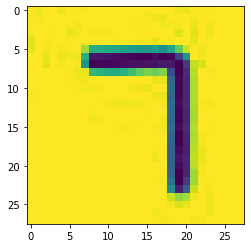

In [4]:
trans = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder(root = "C:/Users/ktash/Downloads/han/train", transform=transforms.ToTensor())
test_dataset = torchvision.datasets.ImageFolder(root = "C:/Users/ktash/Downloads/han/test", transform=transforms.ToTensor())

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

import torch.nn.functional as F

train_iter = iter(train_loader)
images, labels = train_iter.next()
labels = F.one_hot(labels % 5)
print(labels[0][0])
print(labels[0][0].type)
print(len(train_dataset))
print(len(test_dataset))

print(images.shape)
plt.imshow(images[0, 1, :, :])

In [5]:
import torch.nn.functional as F
from qiskit.circuit.random import random_circuit

In [6]:
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    CrossEntropyLoss,
    ELU
)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, PauliFeatureMap, TwoLocal
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

In [8]:
# declare quantum instance
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

In [9]:
# Define QNN
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2, reps=1)
# REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
qnn4 = TwoLayerQNN(
    2, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
)
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [10]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=3, stride=1)
#         self.conv2 = Conv2d(5, 10, kernel_size=3, stride=1)
#         self.conv3 = Conv2d(16, 32, kernel_size=3, stride=1, padding='same')
#         self.dropout = Dropout2d()
        self.fc1 = Linear(338, 16) # have to change
        self.fc2 = Linear(16, 2)
        self.qnn4 = TorchConnector(qnn4)  # Apply torch connector, weights chosen
        self.fc3 = Linear(1, 5)
        self.elu = ELU()
        self.relu = ReLU();

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv3(x))
#         x = F.max_pool2d(x, 2)
#         x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(x))
        x = self.qnn4(x)
        x = self.fc3(x)
        x = self.elu(x)
        return x


model_qcnn = Net()

In [11]:
from torchsummary import summary
summary(model_qcnn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 26, 26]              20
            Linear-2                   [-1, 16]           5,424
               ELU-3                   [-1, 16]               0
            Linear-4                    [-1, 2]              34
               ELU-5                    [-1, 2]               0
    TorchConnector-6                    [-1, 1]               4
            Linear-7                    [-1, 5]              10
               ELU-8                    [-1, 5]               0
Total params: 5,492
Trainable params: 5,492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [12]:
# Define model, optimizer, and loss function
optimizer = optim.SGD(model_qcnn.parameters(), momentum=0.9, lr=0.05) #change learning rate!
loss_func = CrossEntropyLoss()

DEVICE = torch.device('cpu')

# Start training
epochs = 20 #number of epochs
loss_list = []  # Store loss history
model_qcnn.train().to(DEVICE)  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        data = data[:, 0, :, :].reshape((-1, 1, 28, 28)).to(DEVICE)
        output = model_qcnn(data).to(DEVICE)  # Forward pass
        target = F.one_hot(target, num_classes = 5).float().to(DEVICE)
#         print(target.shape)
#         print(output.shape)
#         print(output)
#         print(target)
#         break
        loss = loss_func(output, target).to(DEVICE)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: 1.6148
Training [10%]	Loss: 1.6431
Training [15%]	Loss: 1.6133
Training [20%]	Loss: 1.6159
Training [25%]	Loss: 1.6112
Training [30%]	Loss: 1.6112
Training [35%]	Loss: 1.6129
Training [40%]	Loss: 1.6147
Training [45%]	Loss: 1.6134
Training [50%]	Loss: 1.6115
Training [55%]	Loss: 1.6108
Training [60%]	Loss: 1.6110


KeyboardInterrupt: 

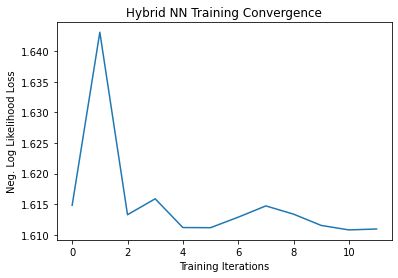

In [13]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [14]:
model_qcnn.eval() # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_qcnn(data[:, 0, :, :].reshape((-1, 1, 28, 28)) * 255)
        
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / 32 * 100
        )
    )

Performance on test data:
	Loss: 1.6115
	Accuracy: 15.6%


In [ ]:
count = 0
fig, axes = plt.subplots(nrows=1, ncols=16, figsize=(10, 3))

model_qcnn.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == 16:
            break
        output = model_qcnn(data[:, 0, :, :].reshape((-1, 1, 28, 28)) * 255)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0, 0, :, :].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title(pred[count][0].item())

        count += 1

In [ ]:
print(qiskit.__qiskit_version__)